# ML-7. Оптимизация гиперпараметров модели

## 1. Введение

Цели модуля:
* Узнать, какие есть базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Узнать, какие есть продвинутые способами оптимизации (Hyperopt, Optuna);
* Научиться их настраивать и обучать модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение и понять преимущества и недостатки каждого из методов


## 2. Базовая оптимизация

In [6]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

C:\Users\kot\AppData\Local\Temp\ipykernel_68920\2150022218.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Описание задачи

### Знакомство с данными и их исследование

In [7]:
#ЕСЛИ РАБОТАЕМ В IDE
data = pd.read_csv('data/_train_sem09.csv')

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Признаки:

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

    Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
    Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Проверяем наличие пропусков

In [8]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [9]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [10]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [11]:
#Создаем объект класса логистическая регрессия
model = linear_model.LogisticRegression(max_iter = 1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

print(metrics.classification_report(y_test, y_pred))


accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       344
           1       0.76      0.80      0.78       407

    accuracy                           0.76       751
   macro avg       0.76      0.75      0.75       751
weighted avg       0.76      0.76      0.76       751



### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


# Аналаиз параметров

попробуем подобрать параметры которые больше всего влияют на итоговую метрику

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]}, # уровень силы регуляризации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.001, 0.1, 0.3, 0.5, 0.7, 0.9]}
]

grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=1,
        max_iter=1000
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
%time grid_search_1.fit(X_train_scaled, y_train)


print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test_scaled, y_test)))

y_test_pred = grid_search_1.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


print("Наилучшие значения параметров: {}".format(grid_search_1.best_params_))


CPU times: total: 1.55 s
Wall time: 7min 22s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения параметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [17]:
print("Наилучшие значения параметров: {}".format(grid_search_1.best_estimator_))

Наилучшие значения параметров: LogisticRegression(C=0.1, max_iter=1000, random_state=1, solver='liblinear')


In [18]:
print("Наилучшие значения метрики: {:.2f}".format(grid_search_1.best_score_))

Наилучшие значения метрики: 0.76


param_solver,lbfgs,liblinear,sag,saga
param_C,,,,
0.01,0.720833,0.744167,0.741500,0.745167
0.10,0.722500,0.756333,0.743500,0.756667
0.30,0.722167,0.755833,0.742167,0.756833
0.50,0.719500,0.752833,0.739833,0.754167
0.70,0.718000,0.748667,0.738167,0.748667
0.90,0.718333,0.747167,0.738000,0.746833
1.00,0.717000,0.745667,0.737667,0.745833


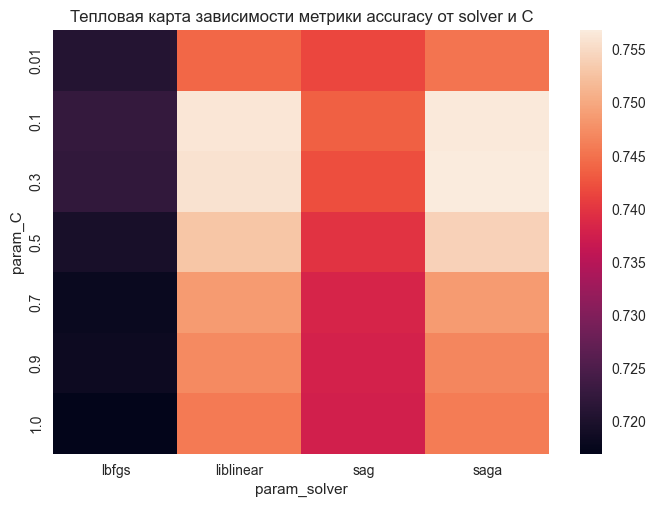

In [19]:
# Взглянем на результаты кросс-валидации
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                values='mean_test_score',
                index='param_C',
                columns='param_solver'
                )
display(visual)
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика



Видим, что алгоритмы оптимизации lbfgs и sag отрицательно влияет на метрику, а C лучше брать от 0.1 до 0.5

### <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [27]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'l1'] ,
              'solver': ['saga', 'liblinear'],
               'C': list(np.linspace(0.1, 1, 10, dtype=float))}

random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distributions,
    cv=5, 
    n_iter=10,
    n_jobs=-1
)

%time random_search.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_train_scaled, y_train)))
y_test_pred = random_search.predict(X_test_scaled)
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))


CPU times: total: 14.3 s
Wall time: 1min 24s
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.79


Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [28]:
param_distributions = {'penalty': ['l2', 'l1'] ,
              'solver': ['saga', 'liblinear'],
               'C': list(np.linspace(0.1, 1, 10, dtype=float))}

random_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_distributions,
    cv=5, 
    n_jobs=-1
)

%time random_search.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_train_scaled, y_train)))
y_test_pred = random_search.predict(X_test_scaled)
print("f1_score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))


CPU times: total: 656 ms
Wall time: 5min 20s
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78


#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [14]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Train score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test_scaled)
print('Test F1 : {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train score: 1.00
Test F1 : 0.81


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [29]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.38 s
Wall time: 12 s
f1_score на обучающем наборе: 0.95
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 170, 'min_samples_leaf': 5, 'max_depth': 22}


In [30]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_distributions, 
    cv=5,
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))


CPU times: total: 2.62 s
Wall time: 37.7 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

### <center> Hyperopt

In [31]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2.7


## Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [52]:
# зафксируем random_state
random_state = 42

def hyperopt_lr(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'penalty': params['penalty'], 
              'solver': params['solver'], 
             'C': params['C']
              }
    model = linear_model.LogisticRegression(**params, random_state=random_state)
    
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean(
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [61]:
pen = ['l1', 'l2']
sol = ['liblinear', 'saga']
space_lr={'penalty': hp.choice('penalty', ['l1', 'l2']), # тип регуляризации
       'solver': hp.choice('solver', ['liblinear', 'saga']), # алгоритм оптимизации
       'C': hp.uniform('C', low=0.01, high=1) # уровень силы регурялизации
      }

In [62]:
# начинаем подбор гиперпараметров
%time

trials_lr = Trials() # используется для логирования результатов

best=fmin(hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials_lr, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: total: 0 ns
Wall time: 0 ns
 15%|█▌        | 3/20 [00:06<00:33,  1.95s/trial, best loss: -0.8760330578512396]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|██        | 4/20 [00:11<00:51,  3.21s/trial, best loss: -0.8760330578512396]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 6/20 [00:15<00:38,  2.72s/trial, best loss: -0.8760330578512396]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 35%|███▌      | 7/20 [00:19<00:39,  3.07s/trial, best loss: -0.8760330578512396]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 55%|█████▌    | 11/20 [00:26<00:18,  2.11s/trial, best loss: -0.8807339449541284]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 60%|██████    | 12/20 [00:30<00:20,  2.61s/trial, best loss: -0.8807339449541284]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 14/20 [00:36<00:18,  3.17s/trial, best loss: -0.8807339449541284]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 75%|███████▌  | 15/20 [00:42<00:19,  3.95s/trial, best loss: -0.8807339449541284]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 85%|████████▌ | 17/20 [00:46<00:09,  3.20s/trial, best loss: -0.8850855745721271]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [00:51<00:07,  3.75s/trial, best loss: -0.8850855745721271]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 95%|█████████▌| 19/20 [00:57<00:04,  4.33s/trial, best loss: -0.8850855745721271]

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [00:58<00:00,  2.91s/trial, best loss: -0.8850855745721271]
Наилучшие значения гиперпараметров {'C': 0.9878598398404349, 'penalty': 1, 'solver': 0}


In [63]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=pen[best['penalty']],
    solver=sol[best['solver']],
    C=float(best['C'])
)

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


## Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [64]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [65]:
# зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean(
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score



In [67]:
# начинаем подбор гиперпараметров
%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))




CPU times: total: 0 ns
Wall time: 0 ns
100%|██████████| 20/20 [00:39<00:00,  1.95s/trial, best loss: -0.988653787181846] 
Наилучшие значения гиперпараметров {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}


In [68]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])    
)

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [69]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.1


## Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [76]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
  solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
  C = trial.suggest_float('C', 0.1, 1, step=0.1)

  # создаем модель
  model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty=penalty,
    solver=solver,
    C=C
)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [77]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=20)

[I 2023-05-27 02:45:52,482] A new study created in memory with name: LogisticRegression
[I 2023-05-27 02:45:52,729] Trial 0 finished with value: 0.8156626506024096 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.2}. Best is trial 0 with value: 0.8156626506024096.
[I 2023-05-27 02:45:53,520] Trial 1 finished with value: 0.8532277710109623 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.6}. Best is trial 1 with value: 0.8532277710109623.
[I 2023-05-27 02:45:54,330] Trial 2 finished with value: 0.8681553992046498 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 1.0}. Best is trial 2 with value: 0.8681553992046498.
[I 2023-05-27 02:45:54,839] Trial 3 finished with value: 0.8597560975609757 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.7000000000000001}. Best is trial 2 with value: 0.8681553992046498.
c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarni

CPU times: total: 36.1 s
Wall time: 35.9 s


In [78]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.0}
f1_score на обучающем наборе: 0.89


In [79]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study_lr.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78


## Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [80]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  

In [81]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-05-27 02:47:10,598] A new study created in memory with name: RandomForestClassifier
[I 2023-05-27 02:47:13,078] Trial 0 finished with value: 0.9138141809290954 and parameters: {'n_estimators': 192, 'max_depth': 18, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9138141809290954.
[I 2023-05-27 02:47:14,344] Trial 1 finished with value: 0.8995098039215685 and parameters: {'n_estimators': 104, 'max_depth': 21, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9138141809290954.
[I 2023-05-27 02:47:16,357] Trial 2 finished with value: 0.9914163090128756 and parameters: {'n_estimators': 119, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9914163090128756.
[I 2023-05-27 02:47:18,743] Trial 3 finished with value: 0.9276777540433324 and parameters: {'n_estimators': 180, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9914163090128756.
[I 2023-05-27 02:47:21,011] Trial 4 finished with value: 0.9119170984455959 and parameters: {'n

CPU times: total: 40.4 s
Wall time: 40.6 s


In [82]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 134, 'max_depth': 21, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [83]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.83
